In [15]:
# download and install system requiriements 
# !pip install -r ../requirements.txt

## 01 - Download and list the root files (signal and background) from Open Data Portal

In [1]:
import subprocess 
import numpy as np

open_data_file_id = "63168"
command = ["cernopendata-client", "get-file-locations", "--recid", open_data_file_id, "--protocol", "xrootd"]
result = subprocess.run(command, capture_output=True, text=True)
filenames = result.stdout.splitlines()
filenames_bkg = np.array(filenames)


open_data_file_id = "33703"
command = ["cernopendata-client", "get-file-locations", "--recid", open_data_file_id, "--protocol", "xrootd"]
result = subprocess.run(command, capture_output=True, text=True)
filenames = result.stdout.splitlines()
filenames_sig = np.array(filenames)
 
# Print the NumPy array
print(filenames_bkg)
print(filenames_sig)

['root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/130000/1C569D85-60AE-7D43-B42B-6D6FD1D66CC7.root'
 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/130000/2EDCC683-1B4B-614B-BEB7-D80BBC20AD8E.root'
 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/270000/19E8D842-3175-1449-AF6C-FD9C69D12724.root'
 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/270000/3957434B-7E09-3B4C-8329-FD44D82C7DB7.root'
 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asy

In [2]:
import uproot
import matplotlib.pylab as plt
import awkward as ak
import numpy as np
from glob import glob

treename = "Events"
branch_dict = {
                "Muon": ["pt", "eta", "phi"],
                "Electron": ["pt", "eta", "phi"],
                "FatJet": ["pt", "eta", "phi"],
                # "MET": ["pt", "phi"]
            }

# make list of branches to read from the dictionary above
branch_names = []
for obj, var in branch_dict.items(): 
    branch_names += [obj + "_" + v for v in var]

infiles_sig = filenames_sig[:] # Lets use all the signal files

## aggregate all data files into one single python oobject
data_sig = uproot.concatenate({fname:"Events" for fname in infiles_sig}, 
                              branch_names, 
                              how = "zip",
                              library = "ak")

# infiles_bkg = ["root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/130000/2EDCC683-1B4B-614B-BEB7-D80BBC20AD8E.root","root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/270000/19E8D842-3175-1449-AF6C-FD9C69D12724.root","root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/270000/3957434B-7E09-3B4C-8329-FD44D82C7DB7.root","root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/270000/397D1673-167A-CF46-9E79-D7069D9AC359.root"]
infiles_bkg = filenames_bkg[:] #Let's use only 4 of the background files, one of the first files seems to not be accessible with xrootd so I take entry 4-8
data_bkg = uproot.concatenate({fname:"Events" for fname in infiles_bkg}, 
                              branch_names, 
                              how = "zip",
                              library = "ak")


# # Here is an example of how you can open a single file rith awkward and regex for the branch expression :

# file_bkg = uproot.open(infiles_bkg[0])
# data_bkg = file_bkg["Events"].arrays(
#     filter_name = "/(Muon|Electron|FatJet|MET)_(pt|eta|phi|sumEt)/", 
#     how = "zip"
# )

In [3]:
type(data_bkg)

awkward.highlevel.Array

Now we have each object grouped in a respective field, and the variables are accesible at the next level (this is a result of using how="zip" when loading)

In [4]:
print(f"Training on N signal samples: {len(data_sig)}")
print(f"Training on N backgr samples: {len(data_bkg)}")

Training on N signal samples: 137000
Training on N backgr samples: 19279000


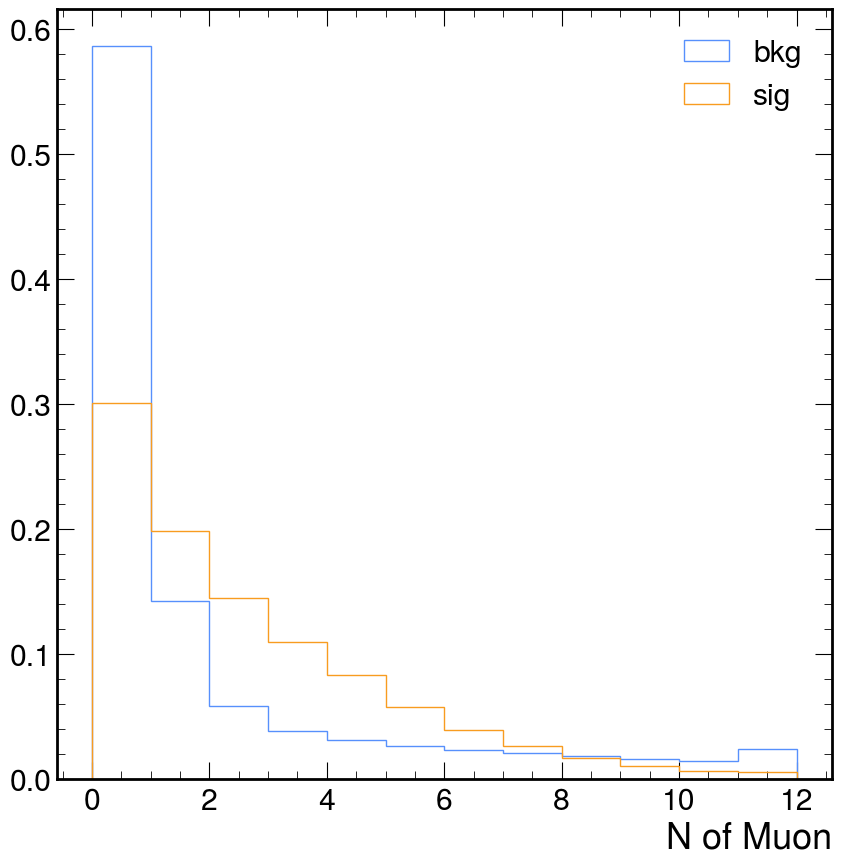

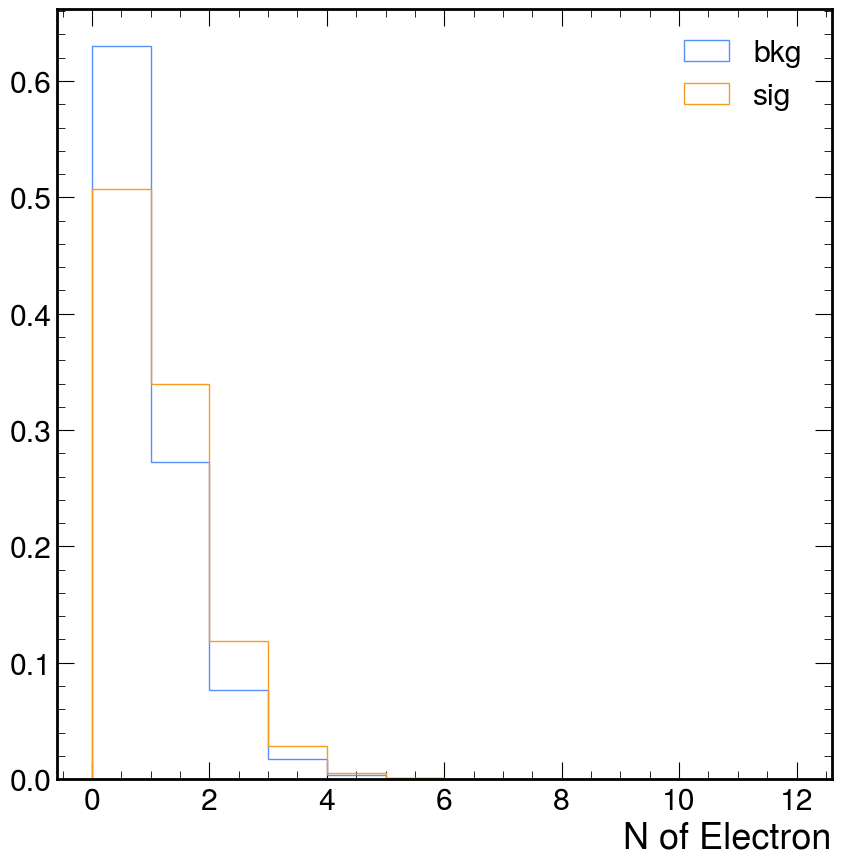

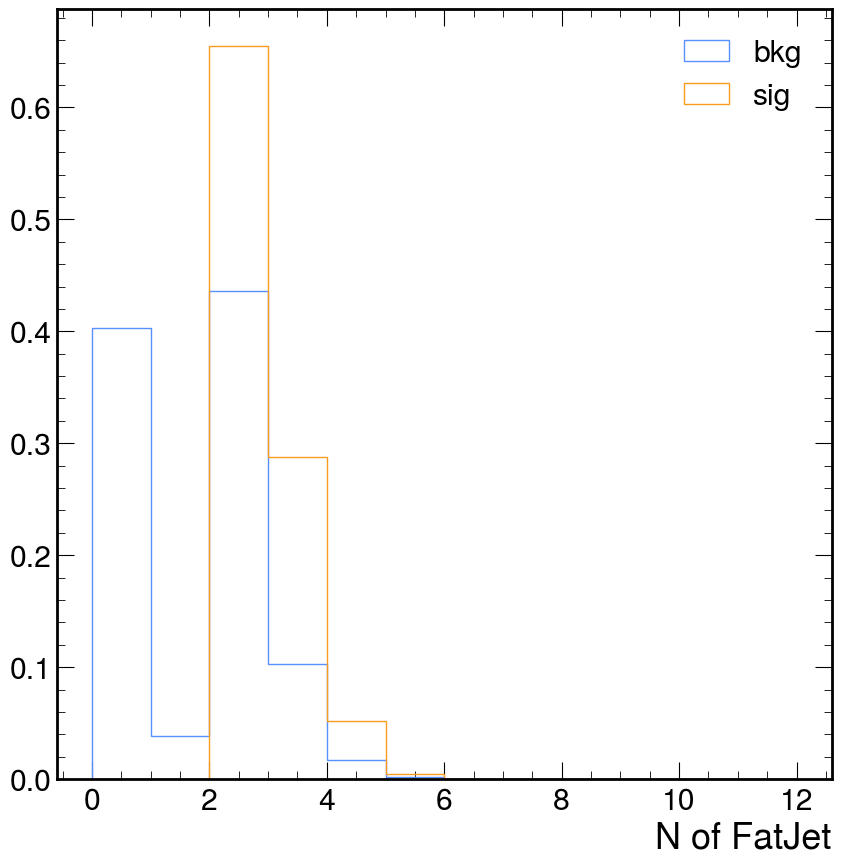

In [5]:
import mplhep
mplhep.style.use('CMS')

for obj in [ 'Muon', 'Electron', 'FatJet']:
    plt.figure()#figsize = (8,4))

    for label, data in zip(["bkg","sig"], [data_bkg, data_sig]):
        num = ak.num(data[obj]) ## convert akward object to numpy array

        # plot the histogram into "CMS" format
        plt.hist(num, label = label, bins = range(13), density = True, 
                 #log = True, 
                 histtype = "step")
        
    plt.xlabel(f"N of {obj}")
    plt.legend()
#     plt.grid()

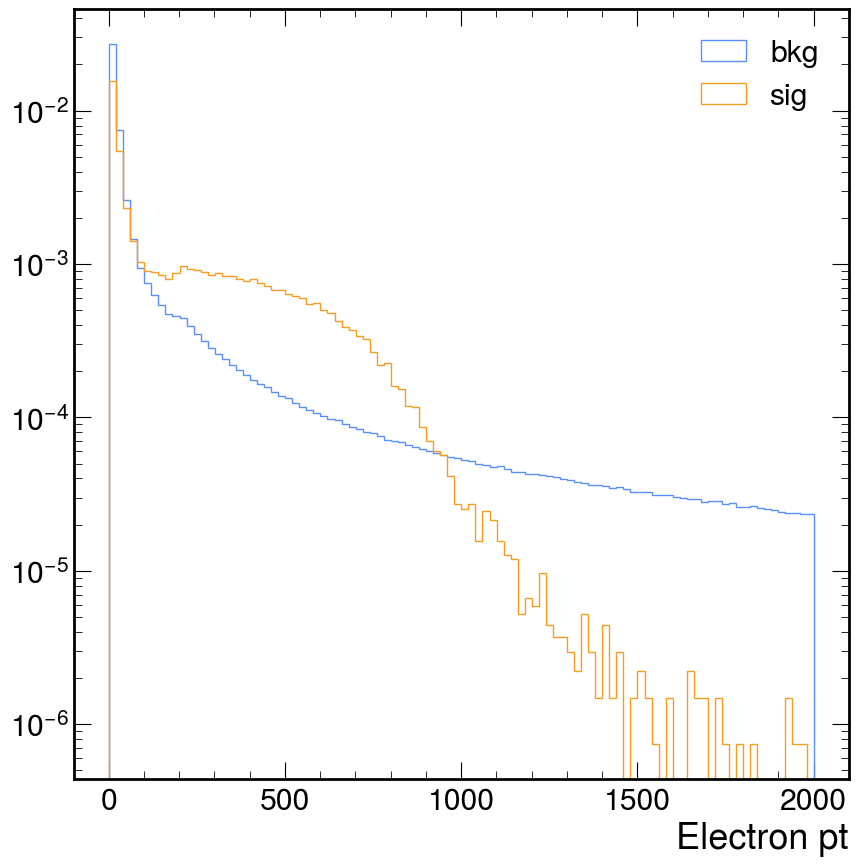

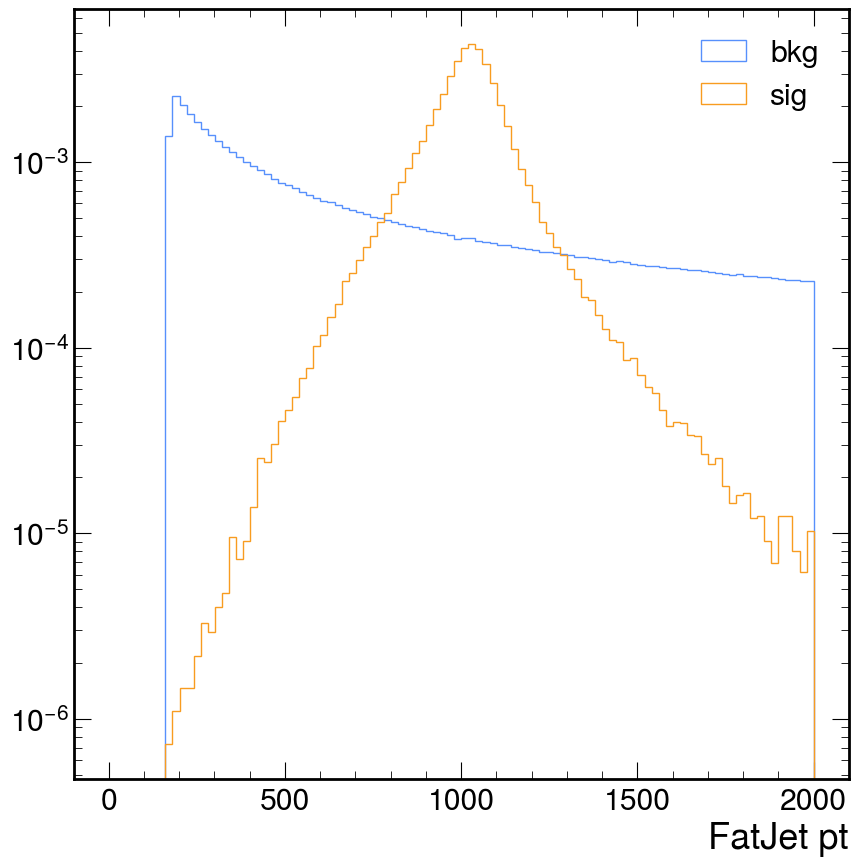

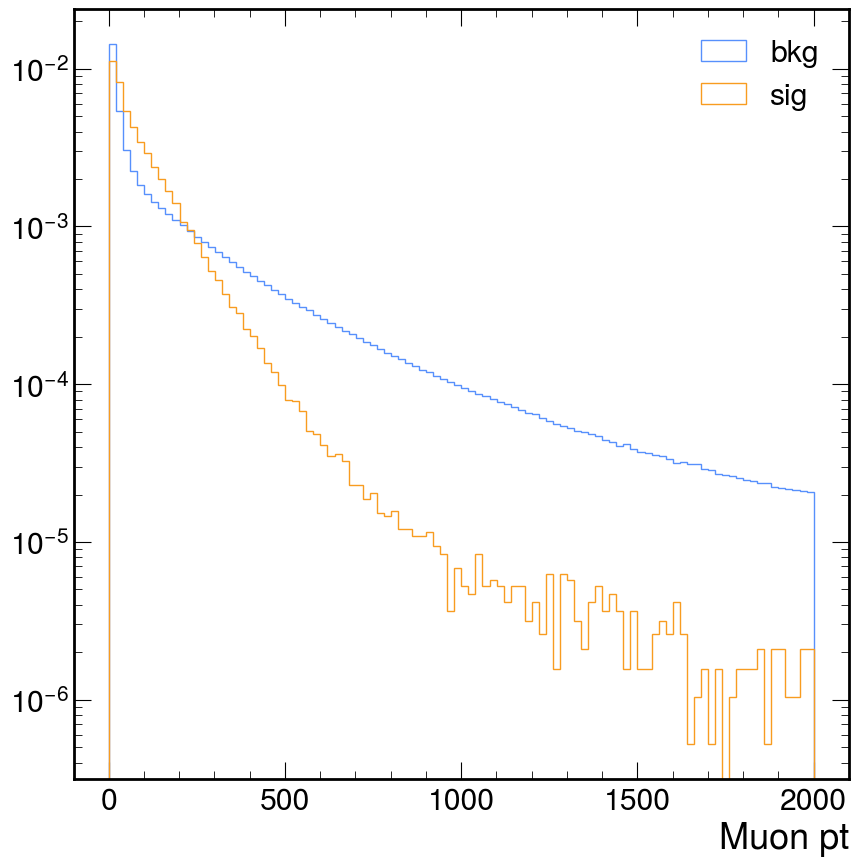

In [24]:
for obj in [ 'Electron', 'FatJet', 'Muon']:
    plt.figure()#figsize = (8,4))

    for label, data in zip(["bkg","sig"], [data_bkg, data_sig]):
        # notice the [:,:1] below -> we slice the array and select no more than the first entry per event
        # ak.ravel makes the array flat such that we can fill a histogram
        plt.hist(ak.ravel(data[obj].pt[:,:1]), label = label, bins = np.linspace(1, 2000, 101), density = True, 
                 log = True, 
                 histtype = "step")
        
    plt.xlabel(f"{obj} pt")
    plt.legend()
#     plt.grid()

# 02 - Convert data to regular array for ML usage

Now we need to convert this to something regular that an ML algorithm can use! We will use dedicated functions to ease this conversion from jagged to regular format

In [25]:
def getPadNParr(events, obj, n_pad, fields, cuts = None, name = None, pad_val = 0):
    '''
    This function filter objects and pads them to a certain length with a given value
    events: events object, usually an 'akward' object
    obj: key of the object we are interested in - MET, Electron, Muon, FatJet, etc.
    n_pad: numbers of the same object in the same event, for the case where there are 2 muons, etc
    fields: list of physical proprieties of the object we want: ["pt", "eta", "phi", ...]
    cuts: cuts to be made to the arrays
    name: same as the key for the object -> MET, Electron, Muon, FatJet, etc.
    pad_val: value to be inserted in the None values of the ak.array, defaults to 0
    '''
    
    objects = events[obj]
    
    if not name: name = obj
    
    pad_arrs = []
    var_names = []
        
    # padding with nones
    pad_arr = ak.pad_none(objects, n_pad, clip=True)
    
    # combining to numpy
    for i in range(n_pad):

        for var in fields:
            pad_arrs += [ak.to_numpy( ak.fill_none(pad_arr[var][:,i], pad_val) )]
            var_names.append( "{}_{}_{}".format(name, i, var) )
            
    return np.stack(pad_arrs), var_names

def formatData(data, objects, verbosity = 0):
    '''
    This function concatenates the padded arrays for different objects.
    It is controlled via a dictionary as defined above

    data: events object, agreggated for all datasets, usually an 'akward' object
    objects: a list of dicts formated as  
        objects = [{"name" : "MET", "key" : "MET", "fields" : ["pt", "phi"], "n_obj" : 1 }, 
                    ...,
                    ]

    verbosity: controls the verbosity of the function, 0 for false, 1 for true

    '''
    
    # this will be filled by all required objects
    dataList = [] 
    varList = []
    
    # loop over the dicts on the object array
    for obj in objects: 
        print(obj)
        dat, names = getPadNParr(data, obj["key"], obj["n_obj"], obj["fields"], obj["cuts"] if "cuts" in obj else None, obj["name"] )
        dataList.append(dat)
        varList += names
        
    if verbosity > 0:
        print("The input variables are the following:")
        print(varList)
                
    # combining and returning (and transforming back so events are along the first axis...)
    return dataList, np.concatenate(dataList, axis = 0).T, varList

In [26]:
objects = [
    # {"name" : "MET", "key" : "MET", "fields" : ["pt", "phi"], "n_obj" : 1 },
    {"name" : "FatJet", "key" : "FatJet", "fields" : ["pt", "eta", "phi"], "n_obj" : 6},
    {"name" : "Electron", "key" : "Electron", "fields" : ["pt", "eta", "phi"], "n_obj" : 4},
    {"name" : "Muon", "key" : "Muon", "fields" : ["pt", "eta", "phi"], "n_obj" : 4}
]
    
dataList_, x_sig, var_names = formatData(data_sig, objects, verbosity = 99) 
dataList, x_bkg, var_names = formatData(data_bkg, objects, verbosity = 0) 

{'name': 'FatJet', 'key': 'FatJet', 'fields': ['pt', 'eta', 'phi'], 'n_obj': 6}
{'name': 'Electron', 'key': 'Electron', 'fields': ['pt', 'eta', 'phi'], 'n_obj': 4}
{'name': 'Muon', 'key': 'Muon', 'fields': ['pt', 'eta', 'phi'], 'n_obj': 4}
The input variables are the following:
['FatJet_0_pt', 'FatJet_0_eta', 'FatJet_0_phi', 'FatJet_1_pt', 'FatJet_1_eta', 'FatJet_1_phi', 'FatJet_2_pt', 'FatJet_2_eta', 'FatJet_2_phi', 'FatJet_3_pt', 'FatJet_3_eta', 'FatJet_3_phi', 'FatJet_4_pt', 'FatJet_4_eta', 'FatJet_4_phi', 'FatJet_5_pt', 'FatJet_5_eta', 'FatJet_5_phi', 'Electron_0_pt', 'Electron_0_eta', 'Electron_0_phi', 'Electron_1_pt', 'Electron_1_eta', 'Electron_1_phi', 'Electron_2_pt', 'Electron_2_eta', 'Electron_2_phi', 'Electron_3_pt', 'Electron_3_eta', 'Electron_3_phi', 'Muon_0_pt', 'Muon_0_eta', 'Muon_0_phi', 'Muon_1_pt', 'Muon_1_eta', 'Muon_1_phi', 'Muon_2_pt', 'Muon_2_eta', 'Muon_2_phi', 'Muon_3_pt', 'Muon_3_eta', 'Muon_3_phi']
{'name': 'FatJet', 'key': 'FatJet', 'fields': ['pt', 'eta', 'p

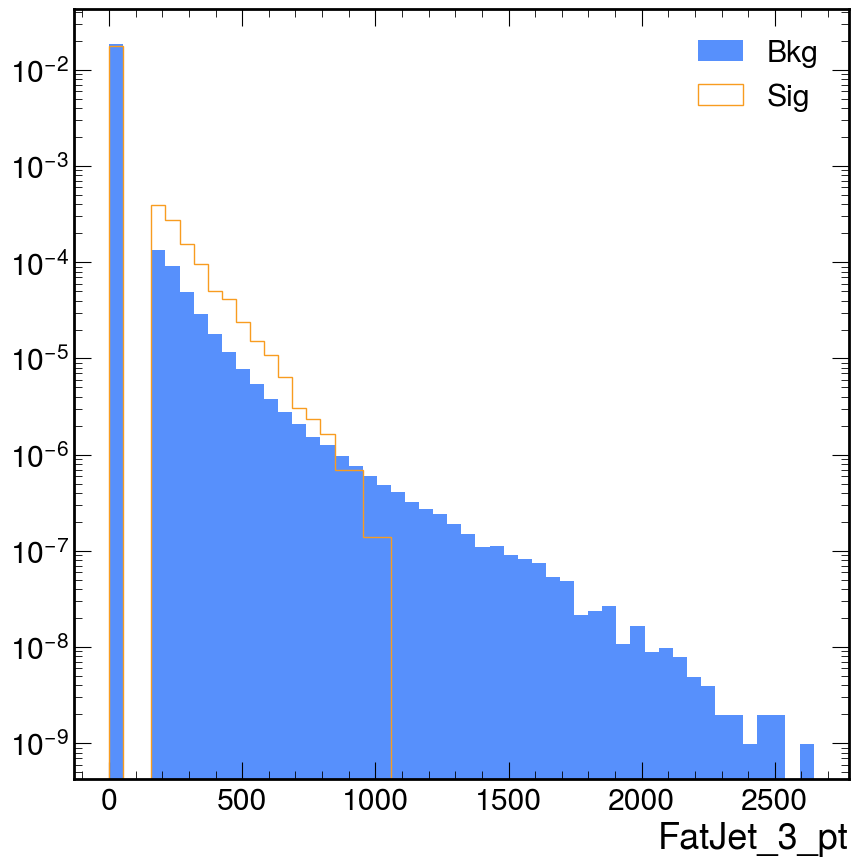

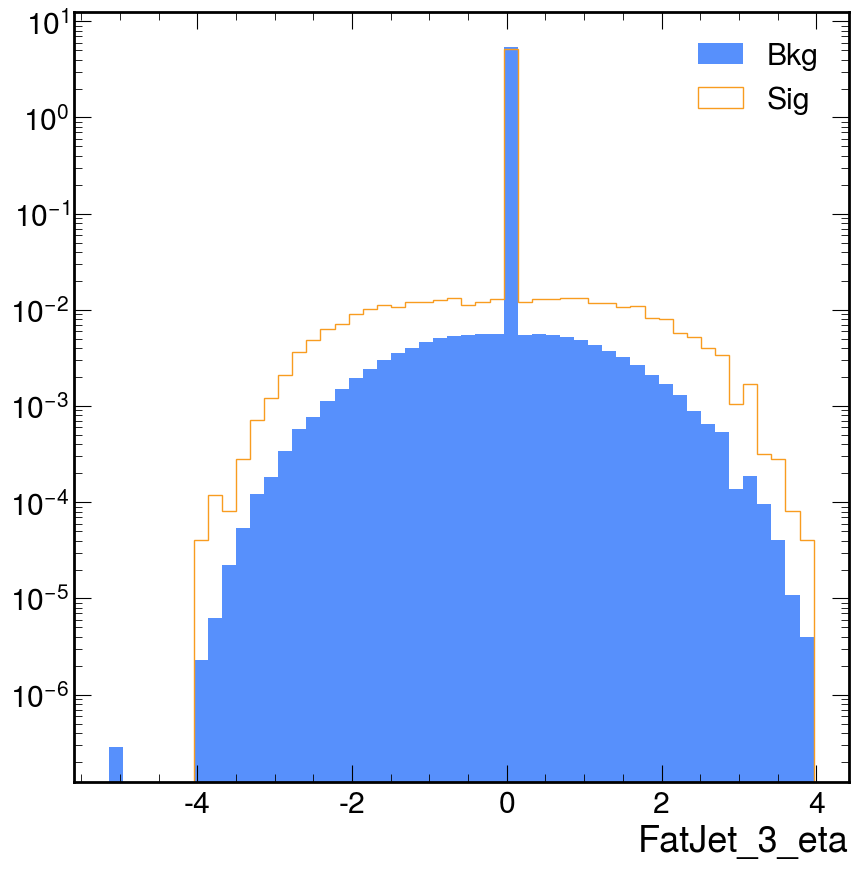

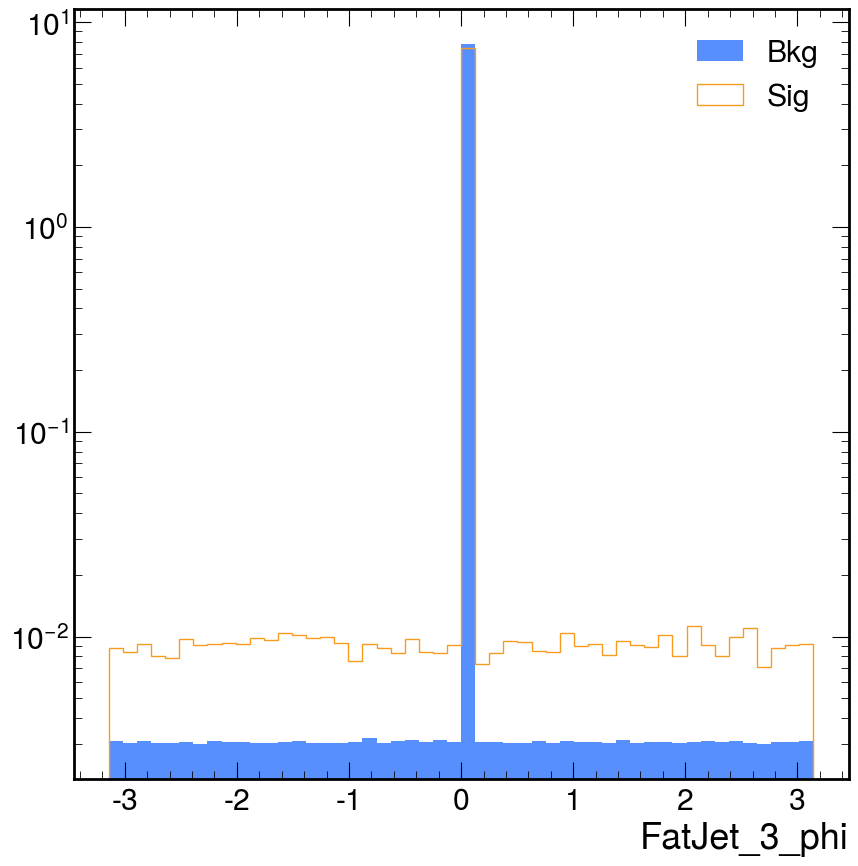

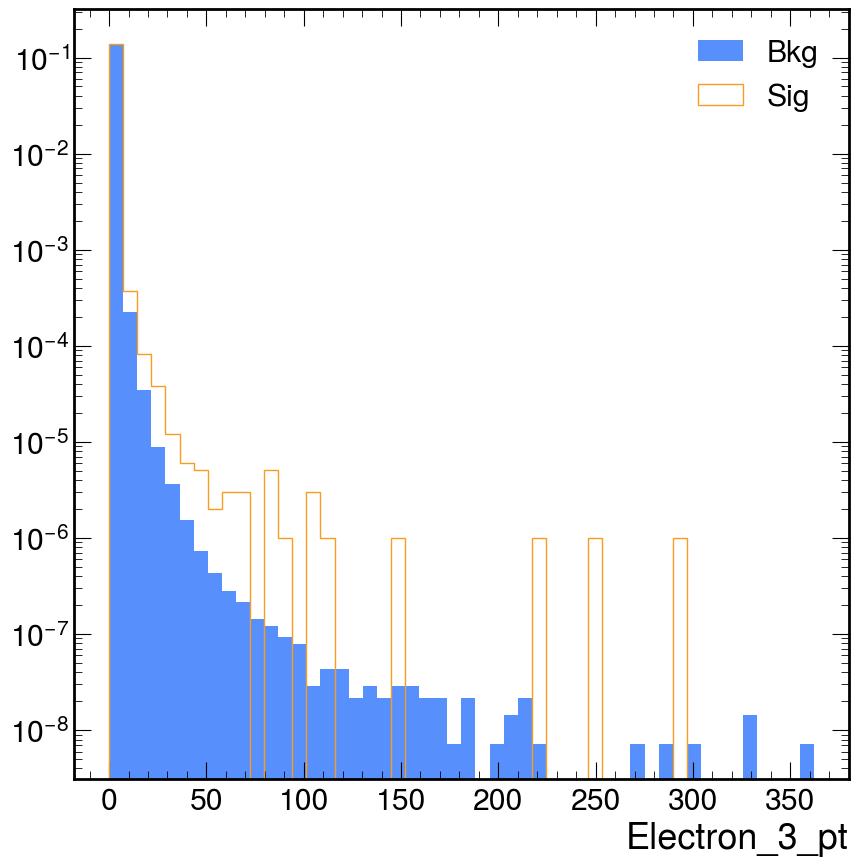

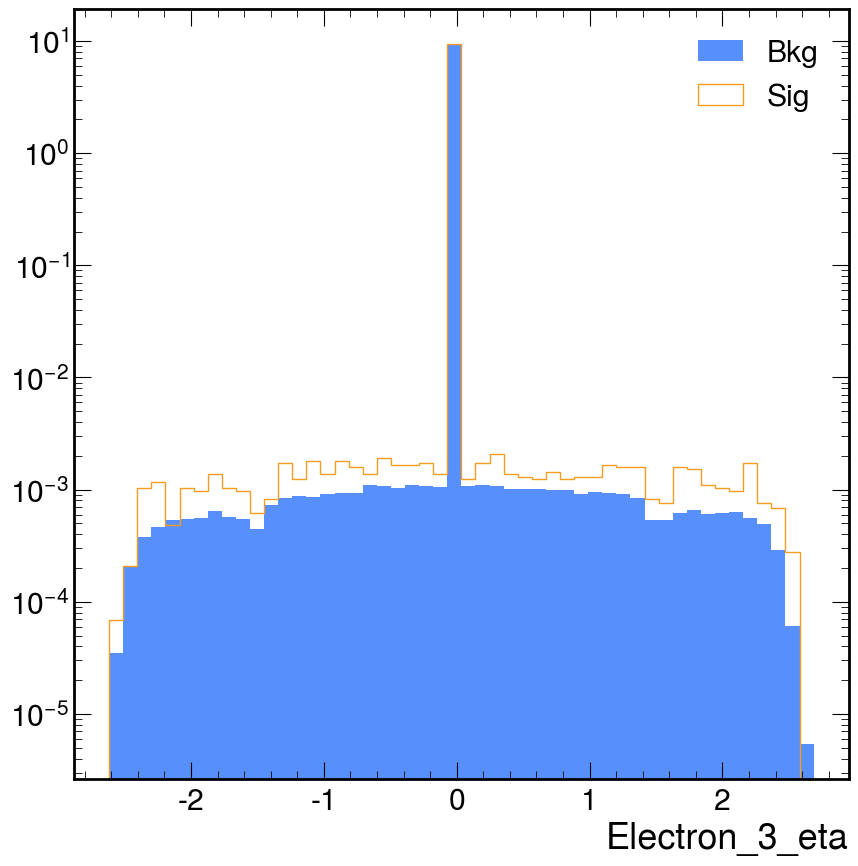

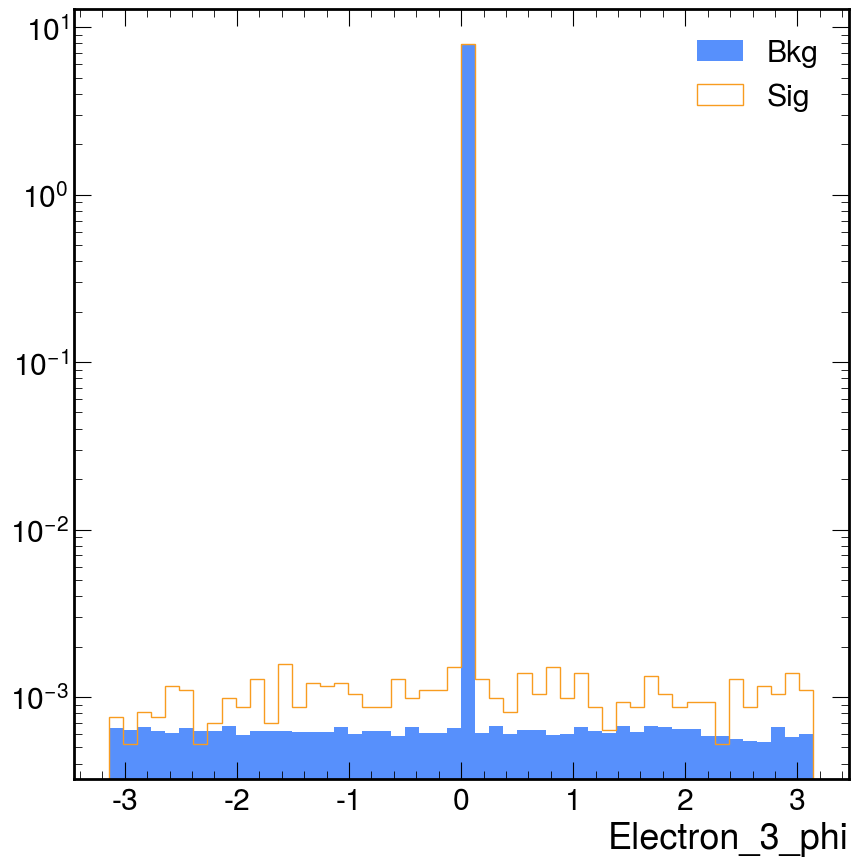

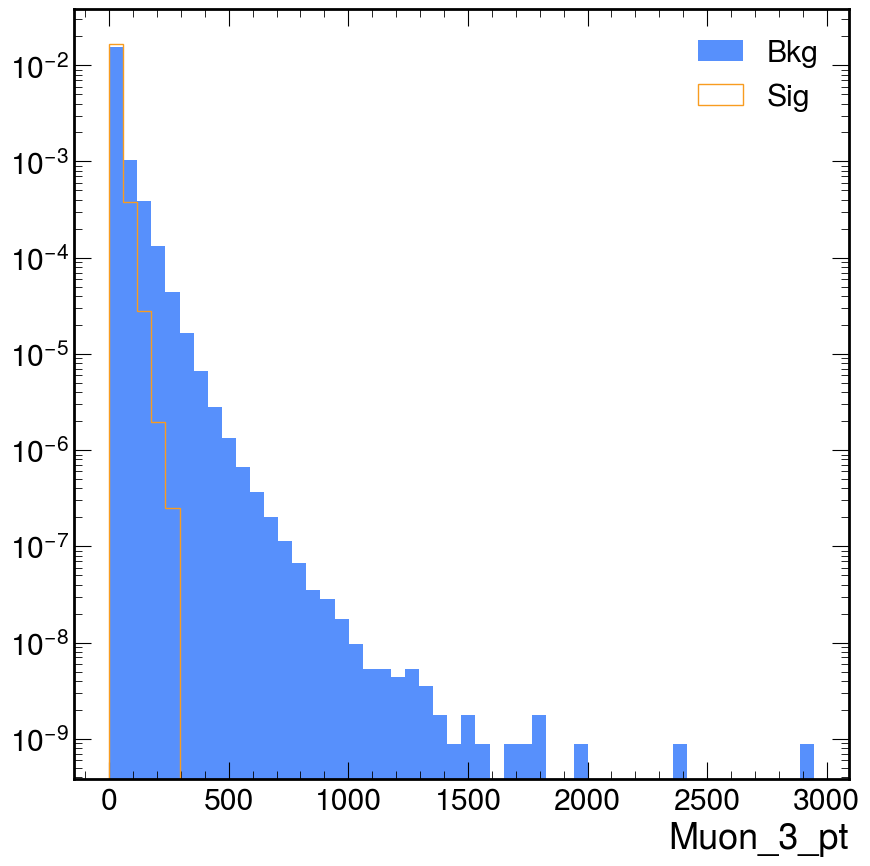

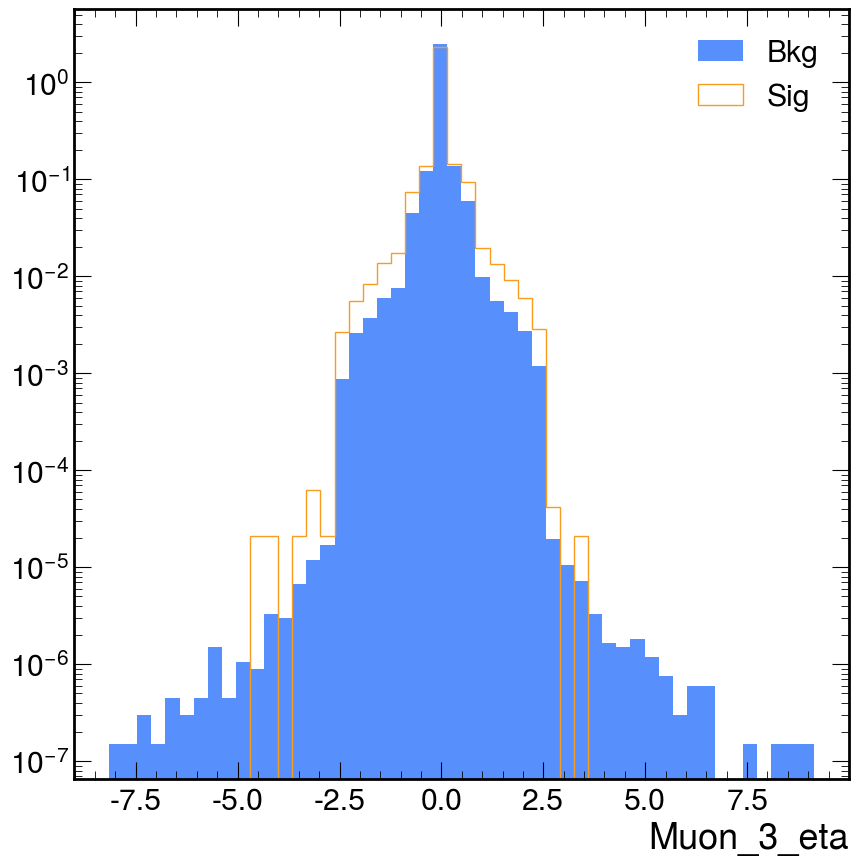

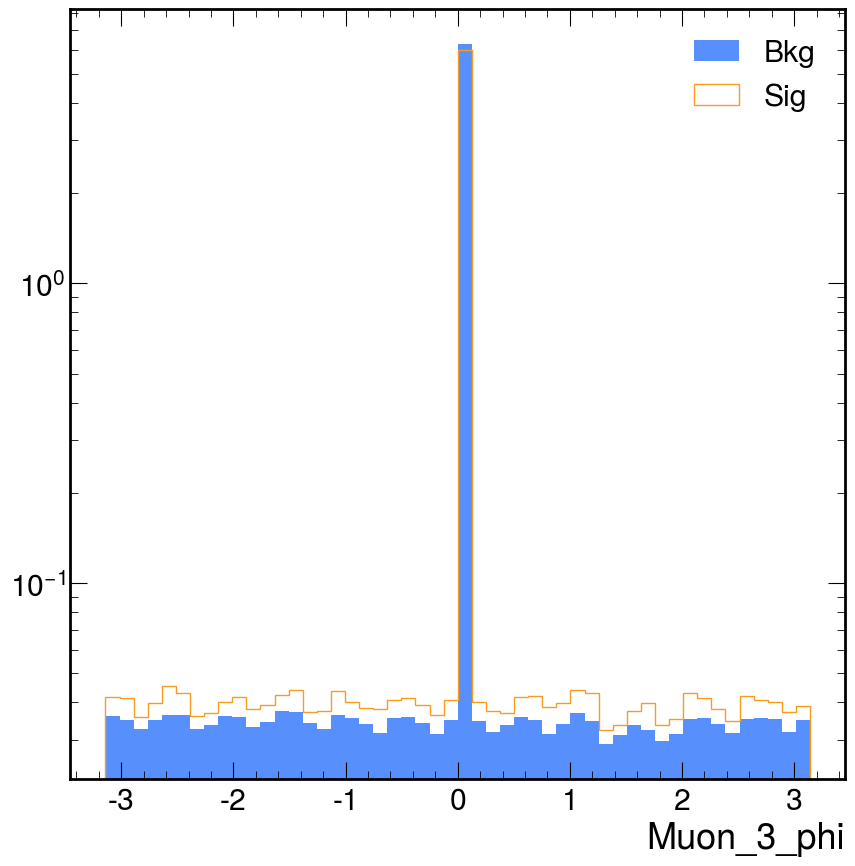

In [27]:
# Let's look at some of the inputs and see whether they make sense!

for i,name in enumerate(var_names[:100]):
    if "_3_" not in name: continue
        
    plt.figure()
    
    _ = plt.hist(x_bkg[:,i], bins = 50, log = True, density = True, label = "Bkg")
    _ = plt.hist(x_sig[:,i], bins = _[1], histtype = "step", density = True, label = "Sig")
    
    plt.xlabel(name)
    plt.legend()
#     break

You can see now that for the non-sum objects we have peaks at 0 as this was the pad_val padding value for filling empty variables. 


# Final preprocessing


Let's prepare the data!
Having very different numerical ranges for the input features, as in this case where $p_T$, $\eta$ and $\phi$ have a very diffent mean, makes it difficult for the network to converge. We will therefore standardize the $p_T$.  Also, when there is no lepton present in the event, the values will be zero padded. That means there is an unnatural number of zero entries in the $p_T$. For a real use case, the loss should be rewritten as to not take zero entries into account. Ideally we would also deal with the periodicity of phi etc. Details on the best procedure for preprccesing can be found in [this paper](https://arxiv.org/abs/2108.03986). In the interest of time, we'll only do the $p_T$ scaling.

In addition, we split the training data into train/test sets and save them: 

In [28]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
_ = scaler.fit(x_bkg)
x_bkg_scaled = scaler.transform(x_bkg)
x_sig_scaled = scaler.transform(x_sig)
    
        
# define training, test and validation datasets
X_train, X_test = train_test_split(x_bkg_scaled, test_size=0.2, shuffle=True)

print("Training data shape = ",X_train.shape)    
with h5py.File('bkg_dataset.h5', 'w') as h5f:
    h5f.create_dataset('X_train', data = X_train)
    h5f.create_dataset('X_test', data = X_test)
    
with h5py.File('signal_dataset.h5', 'w') as h5f2:
    h5f2.create_dataset('Data', data = x_sig_scaled)        


Training data shape =  (15423200, 42)


You  now have two new files in your reposity, `bkg_dataset.h5` and `signal_dataset.h5` which contains your train/test/val data to train the autoencoder, as well as a test data to check your performance on a New Physics signal

In [29]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


with h5py.File('bkg_dataset.h5', 'r') as file:
    X_train = np.array(file['X_train'])
    X_test = np.array(file['X_test'])
    
with h5py.File('signal_dataset.h5', 'r') as file:
    signal_test_data = np.array(file['Data'])

 Training (#samples,#features): (15423200, 42)
 Testing  (#samples,#features): (137000, 42)
Example data (1,57): [-4.46470399e-02  4.74508491e-02 -1.41630380e+00 -7.05533425e-02
  3.56560890e-02  1.12681029e+00  2.59776807e+00  3.04790622e-01
 -2.65275200e-01 -1.22804036e-01 -8.61758721e-05  6.18447117e-05
 -4.44294739e-02 -1.01366319e-04  4.80622519e-04 -1.40251510e-02
  1.73749159e-04  9.03897484e-05 -2.00795429e-01 -6.60405913e-03
  4.76511622e-03 -6.61145074e-02 -5.88322994e-03  2.43227442e-03
 -6.90235930e-02 -2.91744977e-03  1.41242760e-03 -4.88405703e-02
 -1.60817214e-03  1.03027338e-03 -2.69844934e-03  6.62973305e-02
 -1.68731764e+00 -1.64505884e-01  7.41164255e-02 -2.02938084e+00
 -3.19792009e-01 -6.09887180e+00 -1.87480817e+00 -3.72421838e-01
 -2.06586660e-03  7.45775483e-03]


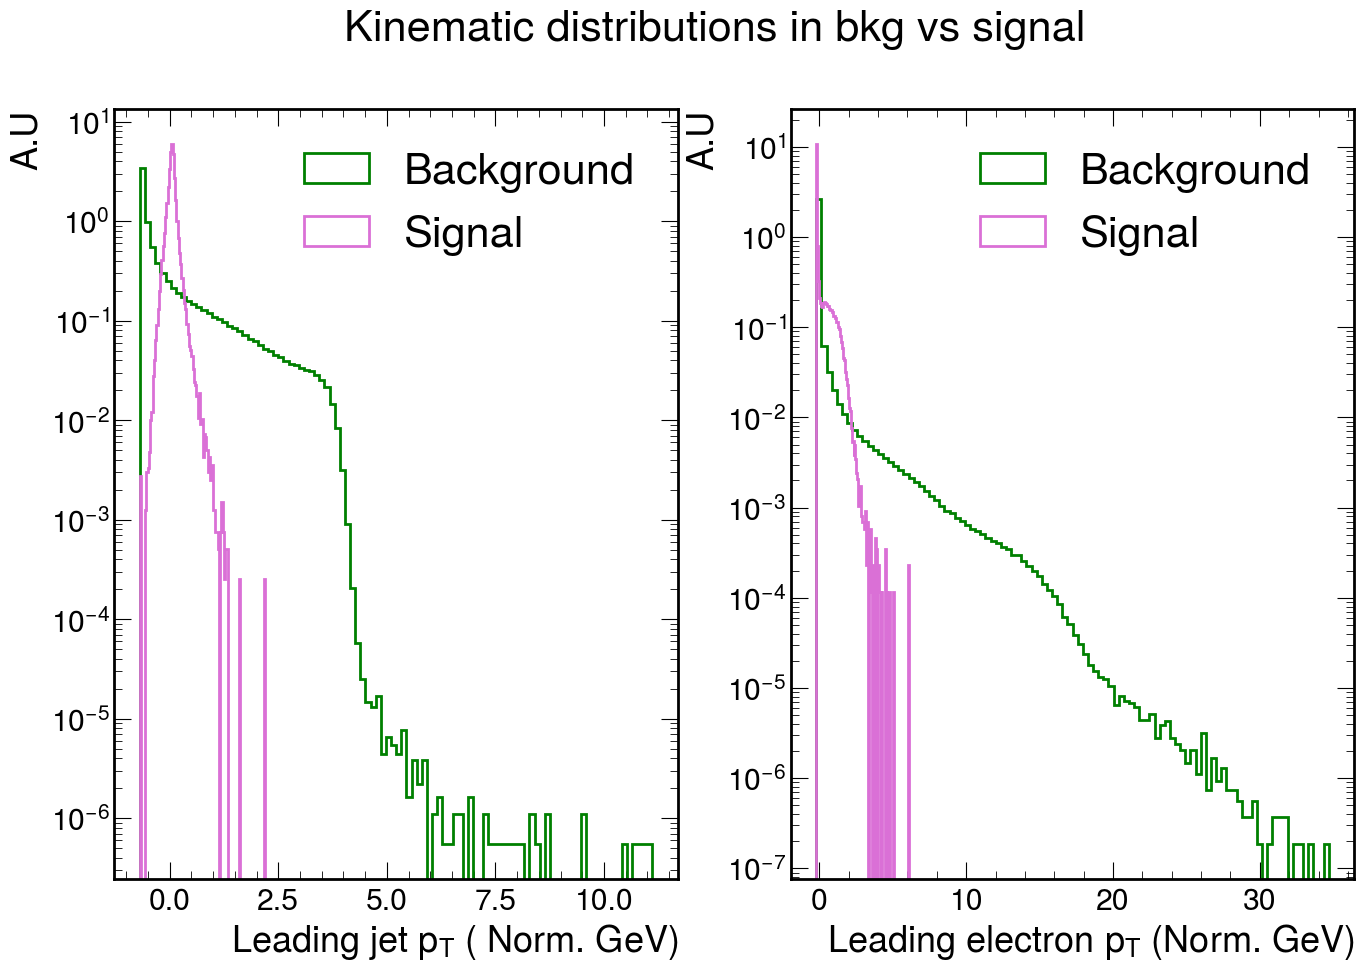

In [30]:
import matplotlib.pyplot as plt

print(" Training (#samples,#features):", X_train.shape)
print(" Testing  (#samples,#features):", signal_test_data.shape)

fig, axs = plt.subplots(1,2,figsize=(16,10))
fig.suptitle('Kinematic distributions in bkg vs signal')

axs[0].hist(X_train[:,0],bins=100,label=r'Background',histtype='step', linewidth=2, facecolor='none', edgecolor='green',fill=True,density=True)
axs[0].hist(signal_test_data[:,0 ],bins=100,label=r'Signal',histtype='step', linewidth=2, facecolor='none', edgecolor='orchid',fill=True,density=True)
axs[0].semilogy()
axs[0].set(xlabel=u'Leading jet $p_{T}$ ( Norm. GeV)', ylabel='A.U')
axs[0].legend(loc='best',frameon=False, ncol=1,fontsize='large')

axs[1].hist(X_train[:,18],bins=100,label=r'Background',histtype='step', linewidth=2, facecolor='none', edgecolor='green',fill=True,density=True)
axs[1].hist(signal_test_data[:,18],bins=100,label=r'Signal',histtype='step', linewidth=2, facecolor='none', edgecolor='orchid',fill=True,density=True)
axs[1].set(xlabel=u'Leading electron $p_{T}$ (Norm. GeV)', ylabel='A.U')
axs[1].semilogy()
axs[1].legend(loc='best',frameon=False, ncol=1,fontsize='large')
print("Example data (1,57):",signal_test_data[3])

# Defining the autoencoder

Now, let's define an autoencoder to learn to reconstruct the training data after compressing it through a bottleneck, then decompressing it again.

<img src="images/ae.png" alt="The autoencoder" width="800" img align="center"/>

For that, we need a stack of dense layers:

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization, Activation, Concatenate, Dropout, Layer
from tensorflow.keras.layers import ReLU, LeakyReLU

In [33]:
'''This code builds an autoencoder using TensorFlow and Keras. An autoencoder is a neural network used to compress and reconstruct data, often for unsupervised learning tasks such as dimensionality reduction, anomaly detection, or noise reduction.

Here’s a breakdown of the code:'''

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization, Activation, Concatenate, Dropout, Layer
from tensorflow.keras.layers import ReLU, LeakyReLU

'''tensorflow and tensorflow.keras are used for building neural networks.
Model, Input, and various layers like Dense, BatchNormalization, LeakyReLU are imported for defining the autoencoder's architecture.'''

input_shape = X_train.shape[1]
latent_dim = 3
'''input_shape: The number of input features is set as the number of columns in X_train. This shape will be the input to the autoencoder.
latent_dim: This defines the size of the latent space (or bottleneck) of the encoder, set to 3. The latent space is a compressed representation of the input data.'''

#encoder
inputArray = Input(shape=(input_shape,))
'''This line creates an input layer of size input_shape (the number of features)'''

#x = BatchNormalization()(inputArray) #Only use this if you're not standardizing the pT
x = Dense(32, kernel_initializer=tf.keras.initializers.HeUniform())(inputArray)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
'''A fully connected (dense) layer with 32 neurons is added with HeUniform initialization, followed by BatchNormalization to normalize activations, and LeakyReLU for non-linearity.'''

x = Dense(16, kernel_initializer=tf.keras.initializers.HeUniform())(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
'''Another dense layer with 16 neurons is added, followed by BatchNormalization and LeakyReLU activation.'''

encoder = Dense(latent_dim, kernel_initializer=tf.keras.initializers.HeUniform())(x)
'''The final layer of the encoder compresses the input data into the latent space, which has a dimension of 3 (latent_dim). This is the output of the encoder.'''


#decoder
x = Dense(16, kernel_initializer=tf.keras.initializers.HeUniform())(encoder)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
'''The decoder begins by reconstructing data from the latent space (3 dimensions). It uses a dense layer with 16 neurons, batch normalization, and LeakyReLU.'''


x = Dense(32, kernel_initializer=tf.keras.initializers.HeUniform())(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
'''Another dense layer with 32 neurons, batch normalization, and LeakyReLU follows, continuing the reconstruction process.'''

decoder = Dense(input_shape, kernel_initializer=tf.keras.initializers.HeUniform())(x)
'''The final layer of the decoder reconstructs the original input with the same shape as the input data (input_shape).'''

#create autoencoder
autoencoder = Model(inputs = inputArray, outputs=decoder)
autoencoder.summary()
'''This line creates a Keras Model, with the input being inputArray (the original input), and the output being decoder (the reconstructed input).
The summary() function displays a summary of the model, showing the layers, output shapes, and number of parameters.'''

'''Key Concepts:
Encoder: Compresses the input data to a lower-dimensional latent space (size 3).
Decoder: Reconstructs the original input from the compressed latent space.
BatchNormalization: Used to normalize activations across layers to speed up training and improve stability.
LeakyReLU: A variant of the ReLU activation function with a small slope for negative inputs (alpha=0.3) to avoid the "dying ReLU" problem.
HeUniform Initialization: A method to initialize weights, which is often used when using ReLU or its variants.
In summary, this code builds an autoencoder with an encoder that compresses input data to 3 dimensions and a decoder that reconstructs the input from these compressed dimensions.'''

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 42)             │         1,386 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,333 (16.93 KB)

 Trainable params: 4,141 (16.18 KB)

 Non-trainable params: 192 (768.00 B)

'Key Concepts:\nEncoder: Compresses the input data to a lower-dimensional latent space (size 3).\nDecoder: Reconstructs the original input from the compressed latent space.\nBatchNormalization: Used to normalize activations across layers to speed up training and improve stability.\nLeakyReLU: A variant of the ReLU activation function with a small slope for negative inputs (alpha=0.3) to avoid the "dying ReLU" problem.\nHeUniform Initialization: A method to initialize weights, which is often used when using ReLU or its variants.\nIn summary, this code builds an autoencoder with an encoder that compresses input data to 3 dimensions and a decoder that reconstructs the input from these compressed dimensions.'

In [34]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='mse')
'''Optimizer: The autoencoder is compiled using the Adam optimizer, which is a popular choice for training deep learning models. The learning rate is set to 0.00001, which is quite small, indicating slower but potentially more stable updates during training.
Loss Function: The loss function used is Mean Squared Error (MSE). This is common in autoencoders, as the model tries to minimize the difference between the input and the reconstructed output. Essentially, the model learns to reconstruct the input with minimal error.'''

# Let's train!

In [35]:
train = True #If you have a pre-trained model you can set this to false and load the other instead
EPOCHS = 150
BATCH_SIZE = 1024
'''train = True indicates that training will take place. If set to False, it will load a pre-trained model instead.
EPOCHS: Set to 150, meaning the model will go through the entire training dataset 150 times.
BATCH_SIZE: Set to 1024, meaning the model will process 1024 samples at a time before updating the weights. This is considered a relatively large batch size.'''

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
'''Callbacks are functions that are executed at certain stages of training (like at the end of an epoch). These help to improve performance and ensure stable training. Three important callbacks are used here:'''



callbacks=[]
callbacks.append(ReduceLROnPlateau(monitor='val_loss',  factor=0.1, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=2, min_lr=1E-6))
'''This callback reduces the learning rate when the validation loss has stopped improving.
monitor='val_loss': It monitors the validation loss.
factor=0.1: Reduces the learning rate by a factor of 10 when triggered.
patience=2: It waits for 2 epochs before reducing the learning rate if no improvement is detected.
min_lr=1E-6: Ensures the learning rate does not go below 1E-6.
This helps avoid overshooting the optimal point in weight space and can lead to better convergence.'''

callbacks.append(TerminateOnNaN())
callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss',verbose=1, patience=10, restore_best_weights=True))

if train:
    history = autoencoder.fit(X_train, X_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
              validation_split=0.2,
              callbacks=callbacks)
    # Save the model
    autoencoder.save('baseline_ae.h5')
    autoencoder.save_weights('baseline_ae.weights.h5')
    
else:
    autoencoder = tf.keras.models.load_model('baseline_ae.h5')

Epoch 1/150
12050/12050 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 1.5979 - val_loss: 0.8823 - learning_rate: 1.0000e-05
Epoch 2/150
12050/12050 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.8536 - val_loss: 0.7971 - learning_rate: 1.0000e-05
Epoch 3/150
12050/12050 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - loss: 0.7915 - val_loss: 0.7673 - learning_rate: 1.0000e-05
Epoch 4/150
12050/12050 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.7820 - val_loss: 0.7465 - learning_rate: 1.0000e-05
Epoch 5/150
12050/12050 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - loss: 0.7438 - val_loss: 0.7299 - learning_rate: 1.0000e-05
Epoch 6/150
12050/12050 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.7431 - val_loss: 0.7160 - learning_rate: 1.0000e-05
Epoch 7/150
12050/12050 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - loss: 0.7281 - val_loss: 0.7033 - learning_rate: 1.0000e-05
Epoch 8/150
12050/12050 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 0.7842 - val_loss: 0.6932 - learning_rate: 1.0000e-05
Epoch 9/150
12050/12050 ━━━━━━━━━━━━━━━━

# Evaluating the model performance

Remember that the key metric we use for anomaly detection is the mean-squared-error: If the error is high, the data is more likely to be anomalous, and if the error is low, the data is similar to the training data (which in our case is SM events). We therefore first need to run `model.predict()` in order to get the AE reconstructed output, both for our vanilla SM test data, and for our new leptoquark signal!

In [36]:
bkg_prediction = autoencoder.predict(X_test)
signal_prediction = autoencoder.predict(signal_test_data)

120494/120494 ━━━━━━━━━━━━━━━━━━━━ 54s 444us/step
4282/4282 ━━━━━━━━━━━━━━━━━━━━ 2s 395us/step


Let's see how well the network reconstructs the transverse momentum of the leptons!

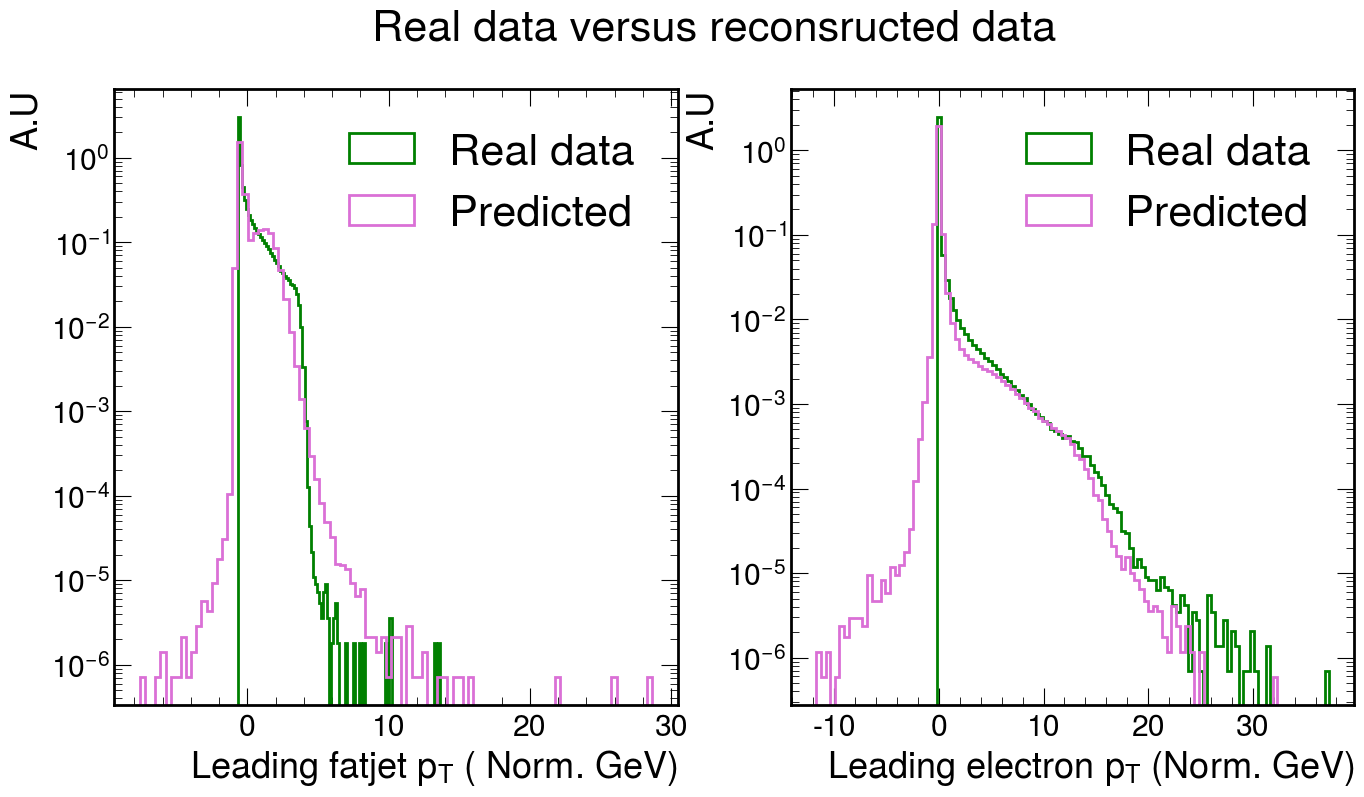

In [37]:
fig, axs = plt.subplots(1,2,figsize=(16,8))
fig.suptitle('Real data versus reconsructed data')
axs[0].hist(X_test[:,0],bins=100,label=r'Real data',histtype='step', linewidth=2, facecolor='none', edgecolor='green',fill=True,density=True)
axs[0].hist(bkg_prediction[:,0],bins=100,label=r'Predicted',histtype='step', linewidth=2, facecolor='none', edgecolor='orchid',fill=True,density=True)
axs[0].semilogy()
axs[0].set(xlabel=u'Leading fatjet $p_{T}$ ( Norm. GeV)', ylabel='A.U')
axs[0].legend(loc='best',frameon=False, ncol=1,fontsize='large')

axs[1].hist(X_test[:,18],bins=100,label=r'Real data',histtype='step', linewidth=2, facecolor='none', edgecolor='green',fill=True,density=True)
axs[1].hist(bkg_prediction[:,18],bins=100,label=r'Predicted',histtype='step', linewidth=2, facecolor='none', edgecolor='orchid',fill=True,density=True)
axs[1].set(xlabel=u'Leading electron $p_{T}$ (Norm. GeV)', ylabel='A.U')
axs[1].semilogy()
axs[1].legend(loc='best',frameon=False, ncol=1,fontsize='large')

The reconstructed $p_T$ has an unphysical tail below zero. For a real usecase, we would force the output to be positive for that column, as well as treat the zero-padded cases differently in the loss.
To keep it short, we won't do that now, but you can read more about it [here](https://arxiv.org/abs/2108.03986)

We then need to compute the mean-square-error, which will be our final discriminating variable. This you would need to write custom if applying the changes we mention above:

In [38]:
def mse_loss(true, prediction):
    loss = tf.reduce_mean(tf.math.square(true - prediction),axis=-1)
    return loss

# compute loss value of input data versus AE reconstructed data
mse_sm = mse_loss(X_test, bkg_prediction.astype(np.float32)).numpy()
mse_bsm = mse_loss(signal_test_data,signal_prediction.astype(np.float32)).numpy()

Now, let's look at our discriminant!

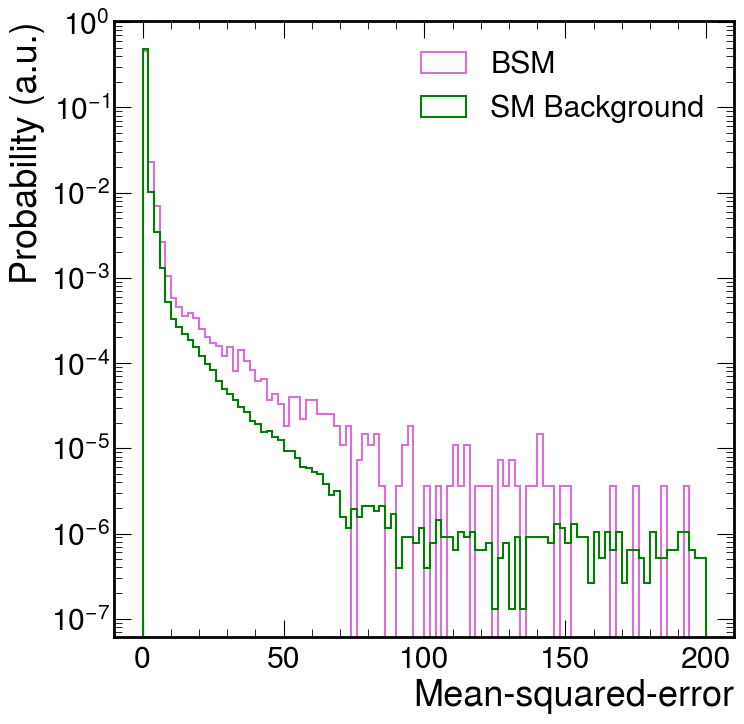

In [39]:
bin_size=100

plt.figure(figsize=(8,8))
n, bins, patches =plt.hist(mse_bsm, bins=bin_size, label="BSM", density = True, histtype='step', fill=False, edgecolor='orchid', linewidth=1.5,range=[0,200])
n_, bins_, patches_ =plt.hist(mse_sm, bins=bin_size, label="SM Background", density = True, histtype='step', fill=False, edgecolor='green', linewidth=1.5,range=[0,200])
plt.yscale('log')
plt.xlabel("Mean-squared-error")
plt.ylabel("Probability (a.u.)")
plt.legend(loc='best')
plt.show()

There seems to be some discrimination power if we cut at very high values of the MSE! Let's look at a ROC curve to make it easier to vizualize

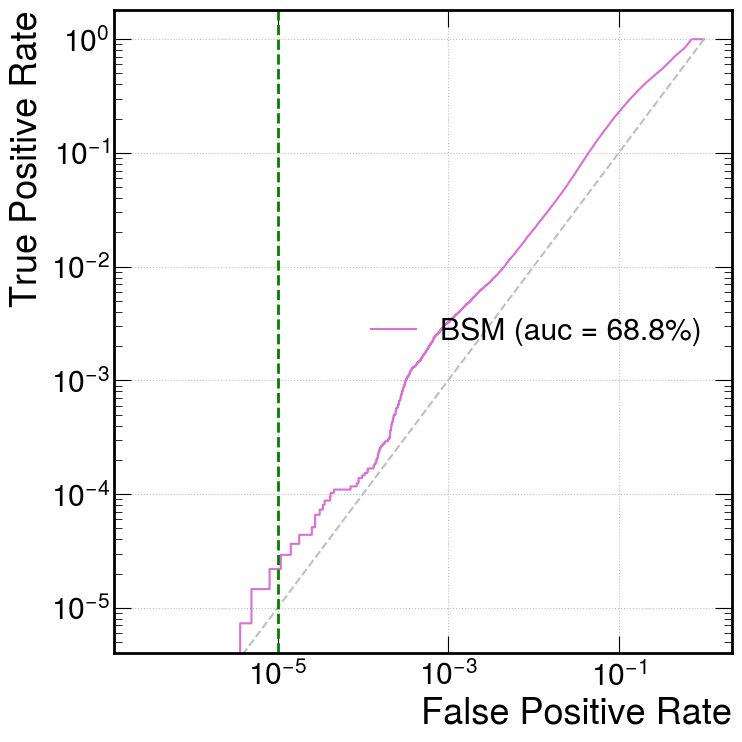

In [40]:
from sklearn.metrics import roc_curve, auc

target_background = np.zeros(mse_sm.shape[0])

plt.figure(figsize=(8,8))
trueVal = np.concatenate((np.ones(mse_bsm.shape[0]), target_background)) # anomaly=1, bkg=0
predVal_loss = np.concatenate((mse_bsm, mse_sm))

fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

auc_loss = auc(fpr_loss, tpr_loss)
    
plt.plot(fpr_loss, tpr_loss, "-", label='BSM (auc = %.1f%%)'%(auc_loss*100.), linewidth=1.5, color = "orchid")
    
plt.semilogx()
plt.semilogy()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc='center right')
plt.grid(True)
plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='green', linestyle='dashed', linewidth=2) # threshold value for measuring anomaly detection efficiency
plt.show()